In [96]:
import csv
from tqdm import tqdm
from flair.nn import Classifier
from flair.data import Sentence
import numpy as np
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

## Pistes d'idées
Tester sur des prompts de manière plus générales
prendre des exemples du dataset IMDB, les modifier et éventuellement déduire de potentiels biais (quels mots pourraient influencer)
Tester et comparer avec un autre modèle de flair que distillbert et voir si lui-même ne serait pas biaisé, car on ne connaît pas le dataset utilisé pour entraîner le modèle de distillbert de flair

Dataset de train utilisé pour le modèle : pas très clair ("un mix de corpus, dont notamment Amazon Review Corpus") (que veulent-ils dire par notamment ?)

Nous effectuons ici une analyse du package Flair, et plus particulièrement de son modèle d'analyse de sentiment, utilisant le modèle "DistillBERT". Nous allons ainsi voir les potentiels biais pouvant apparaître.

Tout d'abord, il est important de noter le flou présent sur les données d'entraînement utilisées pour leurs modèles d'analyse de sentiments. En effet, ils font référence à "un mix de corpus, dont notamment Amazon Review Corpus". On ne sait donc pas exactement le type de review qu'ils ont pu utiliser, si ces données sont elles-mêmes équilibrées en terme de quantité positive/négatives, voire même en terme de type de review. Ils disent "Notamment Amazon Review Corpus", mais on ne sait pas ce que signifie le "notamment" en terme de proportion.

Pour l'évaluation du modèle, nous allons nous baser sur le dataset IMDB Corpus, que l'on suppose avoir été utilisé pour l'entraînement du modèle.

In [4]:
# load the model
tagger = Classifier.load('sentiment')

In [5]:
data = []
with open('imdb.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in reader:
        data.append(row)
data = np.array(data)
        
data_positive = np.array([row for row in data if row[1] == 'positive'])
data_negative = np.array([row for row in data if row[1] == 'negative'])

In [6]:
print(data_positive.shape)
print(data_negative.shape)

(42, 2)
(58, 2)


In [7]:
def get_common_words(data):
    stop_words = set(stopwords.words('english'))
    reviews = data[0].tolist()
    words = []
    for review in reviews:
        tokens = word_tokenize(review)
        words += [token.lower() for token in tokens if token.isalpha() and token.lower() not in stop_words]
    return Counter(words).most_common(10)


In [8]:
get_common_words(data_negative)

[('br', 6),
 ('jake', 4),
 ('parents', 3),
 ('movie', 3),
 ('drama', 3),
 ('closet', 2),
 ('film', 2),
 ('thriller', 2),
 ('basically', 1),
 ('family', 1)]

In [9]:
get_common_words(data_positive)

[('oz', 6),
 ('br', 6),
 ('violence', 4),
 ('show', 3),
 ('prison', 3),
 ('forget', 3),
 ('watching', 2),
 ('episode', 2),
 ('right', 2),
 ('first', 2)]

In [10]:
def compare_sentiment(sentence):
    display(Markdown(sentence))
    prediction = Sentence(sentence)
    tagger.predict(prediction)
    print("Prediction: ", prediction)

In [11]:
def get_accuracy(data):
    correct = 0
    for row in data:
        prediction = Sentence(row[0])
        tagger.predict(prediction)
        if(prediction.labels[0].value.lower() == row[1]):
            correct += 1
    return correct / data.shape[0]

print(get_accuracy(data_positive))
print(get_accuracy(data_negative))
print(get_accuracy(data))

0.8571428571428571
1.0
0.9306930693069307


On remarque que le modèle a déjà plus de mal à identifier une review positive d'une review négative. Les données de test utilisées ici présentent plus de reviews négatives que positives. On peut alors se demander s'il n'y a pas eu un biais dans les données d'entraînement. En effet, il est possible que l'équilibre en terme de quantité de reviews positives vs négatives n'ait pas été respecté. Etant donné l'apparente diversité des données d'entraînement utilisées pour le modèle utilisé par Flair, ainsi que le flou quant à sa composition exacte, on ne peut faire que de simples suggestions à ce sujet.

In [12]:
def get_least_accurate_prediction(data):
    score = 1.0
    least_index = 0
    for index, row in enumerate(data):
        prediction = Sentence(row[0])
        tagger.predict(prediction)
        if(prediction.labels[0].score < score):
            score = prediction.labels[0].score
            least_index = index
    return data[least_index - 1][0], score, least_index


### Analyse des données "complexes" pour le modèle

In [13]:
review, score, index = get_least_accurate_prediction(data_positive)
print(score)
display(Markdown(review))

0.5802236795425415


NO SPOILERS!!<br /><br />After Hitchcock's successful first American film, Rebecca based upon Daphne DuMarier's lush novel of gothic romance and intrigue, he returned to some of the more familiar themes of his early British period - mistaken identity and espionage. As the U.S. settled into World War II and the large scale 'war effort' of civilians building planes, weaponry and other necessary militia, the booming film entertainment business began turning out paranoid and often jingoistic thrillers with war time themes. These thrillers often involved networks of deceptive and skilled operators at work in the shadows among the good, law abiding citizens. Knowing the director was at home in this espionage genre, producer Jack Skirball approached Hitchcock about directing a property he owned that dealt with corruption, war-time sabotage and a helpless hero thrust into a vortex of coincidence and mistaken identity. The darker elements of the narrative and the sharp wit of literary maven Dorothy Parker (during her brief stint in Hollywood before returning to her bohemian roots in NYC) who co-authored the script were a perfect match for Hitchcock's sensibilities.<br /><br />This often neglected film tells the story of the unfortunate 25 year old Barry Kane (Robert Cummings) who, while at work at a Los Angeles Airplane Factory, meets new employee Frank Frye (Norman Lloydd) and moments later is framed for committing sabotage. Fleeing the authorities who don't believe his far-fetched story he meets several characters on his way to Soda City Utah and finally New York City. These memorable characters include a circus caravan with a car full of helpful 'freaks' and a popular billboard model Patricia Martin (Priscilla Lane) who, during the worst crisis of his life as well as national security, he falls madly in love with! Of course in the land of Hitchcock, Patricia, kidnapped by the supposed saboteur Barry, falls for her captor thus adding romantic tension to the mix.<br /><br />In good form for this outing, Hitchcock brews a national network of demure old ladies, average Joes, and respectable businessmen who double as secret agent terrorists that harbor criminals, pull guns and detonate bombs to keep things moving. It's a terrific plot that takes its time moving forward and once ignited, culminates in one of Hitchcock's more memorable finales. Look for incredibly life like NYC tourist attractions (all of which were recreated by art directors in Hollywood due to the war-time 'shooting ban' on public attractions). While Saboteur may not be one of Hitchcock's most well known films, it's a popular b-movie that is certainly solid and engaging with plenty of clever plot twists and as usual - terrific Hitchcock villains. Remember to look for Hitchcock's cameo appearance outside a drug store in the second half of the film. Hitchcock's original cameo idea that was shot (him fighting in sign language with his 'deaf' wife) was axed by the Bureau of Standards and Practices who were afraid of offending the deaf!

Dans le cas ici de la prédiction, le modèle semble moins certain de son résultat. Si on prête un peu plus d'attention à la review en question, on peut comprendre sa difficulté à déterminer si elle est positive ou non. En effet, on remarque que c'est surtout une description détaillée du film en question. L'utilisateur donne peu d'informations quant à la polarité de son avis, ou bien emploie des termes qui peuvent être complexe à comprendre : "*certainly solid and engaging*".

In [56]:
def get_wrong_prediction(data):
    wrong = []
    for row in data:
        prediction = Sentence(row[0])
        tagger.predict(prediction)
        if(prediction.labels[0].value.lower() != row[1]):
            wrong.append((row, prediction.labels[0].score))
    return wrong

In [57]:
wrong_predictions = get_wrong_prediction(data_positive)
for prediction, score in wrong_predictions:
    print("Prediction score : " , score)
    display(Markdown(prediction[0]))
    print("=====================================")

Prediction score :  0.741506814956665


One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.

Prediction score :  0.9998341798782349


Some films just simply should not be remade. This is one of them. In and of itself it is not a bad film. But it fails to capture the flavor and the terror of the 1963 film of the same title. Liam Neeson was excellent as he always is, and most of the cast holds up, with the exception of Owen Wilson, who just did not bring the right feel to the character of Luke. But the major fault with this version is that it strayed too far from the Shirley Jackson story in it's attempts to be grandiose and lost some of the thrill of the earlier film in a trade off for snazzier special effects. Again I will say that in and of itself it is not a bad film. But you will enjoy the friction of terror in the older version much more.

Prediction score :  0.8581662774085999


After the success of Die Hard and it's sequels it's no surprise really that in the 1990s, a glut of 'Die Hard on a .....' movies cashed in on the wrong guy, wrong place, wrong time concept. That is what they did with Cliffhanger, Die Hard on a mountain just in time to rescue Sly 'Stop or My Mom Will Shoot' Stallone's career.<br /><br />Cliffhanger is one big nit-pickers dream, especially to those who are expert at mountain climbing, base-jumping, aviation, facial expressions, acting skills. All in all it's full of excuses to dismiss the film as one overblown pile of junk. Stallone even managed to get out-acted by a horse! However, if you an forget all the nonsense, it's actually a very lovable and undeniably entertaining romp that delivers as plenty of thrills, and unintentionally, plenty of laughs.<br /><br />You've got to love John Lithgows sneery evilness, his tick every box band of baddies, and best of all, the permanently harassed and hapless 'turncoat' agent, Rex Linn as Travers.<br /><br />He may of been Henry in 'Portrait of a Serial Killer' but Michael Rooker is noteworthy for a cringe-worthy performance as Hal, he insists on constantly shrieking in painful disbelief at his captors 'that man never hurt anybody' And whilst he surely can't be, it really does look like Ralph Waite's Frank character is grinning as the girl plummets to her death.<br /><br />Mention too must go to former 'London's Burning' actor Craig Fairbrass as the Brit bad guy, who comes a cropper whilst using Hal as a Human Football, yes, you can't help enjoy that bit, Hal needed a good kicking.<br /><br />So forget your better judgement, who cares if 'that could never happen', lower your acting expectations, turn up the volume and enjoy! And if you're looking for Qaulen, he's the one wearing the helicopter.

Prediction score :  0.8763799667358398


Okay, so this series kind of takes the route of 'here we go again!' Week in, week out David Morse's character helps out his ride who is in a bit of a pickle - but what's wrong with that!? David Morse is one of the greatest character actors out there, and certainly the coolest, and to have him in a series created by David Koepp - a great writer - is heaven!!<br /><br />Due to the lack of love for this show by many, I can't see it going to a season series - but you never know? The amount of rubbish that has made it beyond that baffles me - let's hope something good can make it past a first series!!!

Prediction score :  0.9063156247138977


Preston Sturgis' THE POWER AND THE GLORY was unseen by the public for nearly twenty or thirty years until the late 1990s when it resurfaced and even showed up on television. In the meantime it had gained in notoriety because Pauline Kael's THE CITIZEN KANE BOOK had suggested that the Herman Mankiewicz - Orson Welles screenplay for KANE was based on Sturgis' screenplay here. As is mentioned in the beginning of this thread for the film on the IMDb web site, Kael overstated her case.<br /><br />There are about six narrators who take turns dealing with the life of Charles Foster Kane: the newsreel (representing Ralston - the Henry Luce clone), Thatcher's memoirs, Bernstein, Jed Leland, Susan Alexander Kane, and Raymond the butler. Each has his or her different slant on Kane, reflecting their faith or disappointment or hatred of the man. And of course each also reveals his or her own failings when they are telling their version of Kane's story. This method also leads to frequent overlapping re-tellings of the same incident.<br /><br />This is not the situation in THE POWER AND THE GLORY. Yes, like KANE it is about a legendary business leader - here it is Tom Garner (Spencer Tracy), a man who rose from the bottom to being head of the most successful railroad system in the country. But there are only two narrators - they are Garner's right hand man Henry (Ralph Morgan) and his wife (Sarah Padden). This restricts the nearly three dimensional view we get at times of Kane in Garner. Henry, when he narrates, is talking about his boss and friend, whom he respected and loved. His wife is like the voice of the skeptical public - she sees only the flaws in Henry.<br /><br />Typical example: Although he worked his way up, Tom becomes more and more anti-labor in his later years. Unions are troublemakers, and he does not care to be slowed down by their shenanigans. Henry describes Tom's confrontation with the Union in a major walk-out, and how it preoccupied him to the detriment of his home life. But Henry's wife reminds him how Tom used scabs and violence to end the strike (apparently blowing up the Union's headquarters - killing many people). So we have two views of the man but one is pure white and one is pure black.<br /><br />I'm not really knocking THE POWER AND THE GLORY for not duplicating KANE's success (few films do - including all of Orson Welles' other films), but I am aware that the story is presented well enough to hold one's interest to the end. And thanks to the performances of Tracy and Colleen Moore as his wife Sally, the tragedy of the worldly success of the pair is fully brought home.<br /><br />When they marry, Tom wants to do well (in part) to give his wife and their family the benefits he never had. But in America great business success comes at a cost. Tom gets deeply involved with running the railroad empire (he expands it and improves it constantly). But it takes him away from home too much, and he loses touch with Sally. And he also notices Eve (Helen Vinson), the younger woman who becomes his mistress. When Sally learns of his unfaithful behavior it destroys her.<br /><br />Similarly Tom too gets a full shock (which makes him a martyr in the eyes of Henry). Eve marries Tom, and presents him with a son - but it turns out to be Eve's son by Tom's son Tom Jr. (Philip Trent). The discovery of this incestuous cuckolding causes Tom to shoot himself.<br /><br />The film is not a total success - the action jumps at times unconvincingly. Yet it does make the business seem real (note the scene when Tom tells his Board of Directors about his plans to purchase a small rival train line, and he discusses the use of debentures for financing the plans). Sturgis came from a wealthy background, so he could bring in this type of detail. So on the whole it is a first rate film. No CITIZEN KANE perhaps, but of interest to movie lovers as an attempt at business realism with social commentary in Depression America.

Prediction score :  0.5802236795425415


I just watched The Dresser this evening, having only seen it once before, about a dozen years ago.<br /><br />It's not a "big" movie, and doesn't try to make a big splash, but my God, the brilliance of the two leads leaves me just about speechless. Albert Finney and Tom Courtenay are nothing less than amazing in this movie.<br /><br />The Dresser is the story of Sir, an aging Shakespearean actor (Finney), and his dresser Norman (Courtenay), sort of a valet, putting on a production of King Lear during the blitz of London in World War II. These are two men, each dependent upon the other: Sir is almost helpless without the aid of Norman to cajole, wheedle, and bully him into getting onstage for his 227th performance of Lear. And Norman lives his life vicariously through Sir; without Sir to need him, he is nothing, or thinks he is, anyway.<br /><br />This is a character-driven film; the plot is secondary to the interaction of the characters, and as such, it requires actors of the highest caliber to bring it to life. Finney, only 47 years old, is completely believable as a very old, very sick, petulant, bullying, but brilliant stage actor. He hisses and fumes at his fellow actors even when they're taking their bows! And Courtenay is no less convincing as the mincing dresser, who must sometimes act more as a mother than as a valet to his elderly employer. Employer is really the wrong term to use, though. For although, technically their relationship is that of employer and employee, most of the time Sir and Norman act like nothing so much as an old married couple.<br /><br />Yes, there are others in the cast of this movie, but there is no question that the true stars are Finney, Courtenay, and the marvelous script by Ronald Harwood. That is not to say that there aren't other fine performances, most notably Eileen Atkins as the long-suffering stage manager Madge. There is a wonderful scene where Sir and Madge talk about old desires, old regrets, and what might have been.<br /><br />Although it doesn't get talked about these days, it is worth remembering that The Dresser was nominated for five Academy Awards: Best Actor nominations for both Finney and Courtenay, Best Picture, Best Director (Peter Yates), and Best Adapted Screenplay.<br /><br />I had remembered this as being a good movie, but I wasn't prepared to be as completely mesmerized as I was from beginning to end. If you want to see an example of what great acting is all about, and be hugely entertained all the while, then I encourage you to see The Dresser.

On remarque plusieurs éléments notables dans les prédictions ratées du modèle (On ne compare ici que les faux négatifs étant donné qu'il propose un score de 100% pour les reviews négatives). Tout d'abord, on peut remarquer que certaines reviews semblent à première vue être négative, mais ne le sont en fait pas (les reviews 2, 3, 4, 5 et 6). 

En effet, les utilisateurs semblent critiquer le film/la série en question, en suggérant cependant que malgré le fait que ce ne soit pas un bon film/série, il recommande quand même de le voir (ex: Deuxième review :"*Again I will say that in and of itself it is not a bad film. But you will enjoy the friction of terror in the older version much more.*" : Cela laisse suggérer que le film n'est pas forcément mauvais, mais n'est pas non plus vraiment bon pour autant, ce qui peut faire douter quand à l'avis de l'utilisateur concernant le film). De plus, la deuxième review est assez critique au début, en exprimant clairement que ce film n'aurait pas dû être réalisé. On peut alors en déduire que le modèle a pu être induit en erreur par les propos à nuancer de l'utilisateur.

Si on prend maintenant la quatrième review, l'utilisateur emploie plusieurs termes à connotation négative (*rubbish, lack of love, baffles me*) qui semblent être utilisé dans un but d'exprimer sa frustration quant à l'industrie du cinéma en lui-même, ce qui peut ainsi induire en erreur le modèle.

Enfin, la première review semble aussi poser problème par l'emploi de termes qui sont à connotation négatives, du domaine de la violence et du gore notamment. On remarque également des références à des ethnies ou appartenances à un groupe diverses pouvant pour certaines être souvent apparentées à des connotations négatives. On peut alors prendre cet extrait et voir si modifier ces ethnies peuvent influencer le modèle sur sa confiance, voire sa décision en elle-même.

positive 0.5844309329986572
positive 0.6066145300865173
positive 0.654096782207489
positive 0.5718767642974854
positive 0.6207082271575928
positive 0.5717363357543945
positive 0.5371869206428528
negative 0.6818954944610596


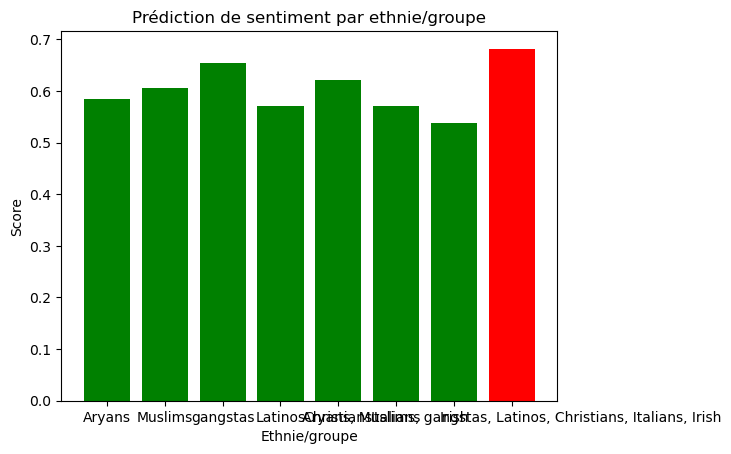

In [113]:
review_start = "One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me. The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word. It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many.."  
review_end = "and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away. I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side."
ethnics = ["Aryans", "Muslims", "gangstas", "Latinos", "Christians", "Italians", "Irish", "Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish"]

predictions = []
scores = []
for ethnicity in ethnics:
    review = review_start + ethnicity + review_end
    prediction = Sentence(review)
    tagger.predict(prediction)
    predictions.append(prediction.labels[0].value.lower())
    scores.append(prediction.labels[0].score)
    print(prediction.labels[0].value.lower(), prediction.labels[0].score)

colors = ['green' if pred == 'positive' else 'red' for pred in predictions]

plt.bar(ethnics, scores, color=colors)
plt.xlabel('Ethnie/groupe')
plt.ylabel('Score')
plt.title('Prédiction de sentiment par ethnie/groupe')
plt.show()

Si on prend chaque ethnies à part une par une, on remarque de suite que la review devient positive, et le reste peu importe l'ethnie ou le groupe conservé. Le score varie mais reste cependant toujours à peu près au même niveau. On peut alors en déduire que le modèle est potentiellement influencé par une combinaison d'ethnies et/ou de groupe plutôt qu'un seul élément.

On peut ensuite s'intéresser uniquement à la partie traitant de ce sujet, afin de voir le comportement du modèle sur cet aspect là en particulier.

positive 0.6426053643226624
positive 0.820826530456543
positive 0.8959290385246277
positive 0.8021716475486755
positive 0.8452346324920654
positive 0.7268381714820862
positive 0.8197156190872192
negative 0.8186808824539185


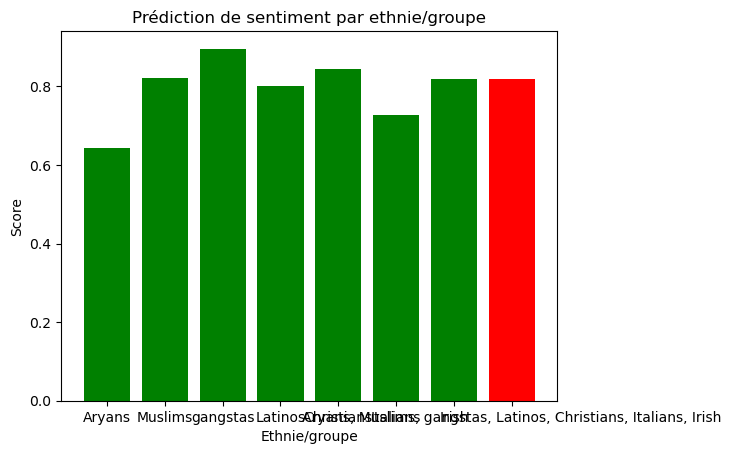

In [114]:
extract_start = "Em City is home to many.." 
extract_end = " and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away."

predictions = []
scores = []
for ethnicity in ethnics:
    review = extract_start + ethnicity + extract_end
    prediction = Sentence(review)
    tagger.predict(prediction)
    predictions.append(prediction.labels[0].value.lower())
    scores.append(prediction.labels[0].score)
    print(prediction.labels[0].value.lower(), prediction.labels[0].score)

colors = ['green' if pred == 'positive' else 'red' for pred in predictions]

plt.bar(ethnics, scores, color=colors)
plt.xlabel('Ethnie/groupe')
plt.ylabel('Score')
plt.title('Prédiction de sentiment par ethnie/groupe')
plt.show()

On remarque que malgré le vocabulaire à connotation de violence, le modèle donne tout de même une review positive si l'on prend les ethnies/groupe un par un.

In [16]:
review, score, index = get_least_accurate_prediction(data_negative)
print(score)
display(Markdown(review))

0.6443233489990234


Average (and surprisingly tame) Fulci giallo which means it's still quite bad by normal standards, but redeemed by its solid build-up and some nice touches such as a neat time twist on the issues of visions and clairvoyance.<br /><br />The genre's well-known weaknesses are in full gear: banal dialogue, wooden acting, illogical plot points. And the finale goes on much too long, while the denouement proves to be a rather lame or shall I say: limp affair.<br /><br />Fulci's ironic handling of giallo norms is amusing, though. Yellow clues wherever you look.<br /><br />3 out of 10 limping killers

Ici, 

In [17]:
# make a sentence
sentence = Sentence('the driver was a woman')

# predict NER tags
tagger.predict(sentence)

# print sentence with predicted tags
print(sentence)

Sentence[5]: "the driver was a woman" → POSITIVE (0.5925)
